In [1]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
#!pip install --upgrade scipy


In [3]:
df = pd.read_csv('ipl1.csv')
df.head(10)

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222
5,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.5,2,0,0,0,222
6,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,3,0,0.6,3,0,0,0,222
7,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,Z Khan,3,0,1.1,3,0,0,0,222
8,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,Z Khan,7,0,1.2,7,0,4,0,222
9,1,18-04-2008,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,Z Khan,11,0,1.3,11,0,8,0,222


In [4]:
df.tail(10)

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
76004,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,JD Unadkat,114,7,18.5,36,1,35,12,129
76005,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,JD Unadkat,115,7,18.6,36,1,36,12,129
76006,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,116,7,19.0,37,0,36,12,129
76007,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,116,7,19.1,37,0,36,12,129
76008,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,120,7,19.2,40,0,40,12,129
76009,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,121,7,19.2,40,0,40,12,129
76010,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,127,7,19.3,46,0,46,12,129
76011,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,128,7,19.4,47,0,47,12,129
76012,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,MG Johnson,DT Christian,129,7,19.5,48,0,47,13,129
76013,617,21-05-2024,"Rajiv Gandhi International Stadium, Uppal",Mumbai Indians,Rising Pune Supergiant,KH Pandya,DT Christian,129,8,19.6,47,1,47,13,129


In [5]:
from datetime import datetime

# Convert the date column to datetime using the correct format
#df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
# Convert the 'date' column to datetime
#df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)

#cols_to_drop = ['mid','batsman','bowler','striker','non-striker']
#df.drop(cols_to_drop,axis=1,inplace=True)

# Drop only the columns that are in the DataFrame
cols_to_drop = ['mid', 'batsman', 'bowler', 'striker', 'non-striker']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# convert the date column to datetime column
#df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

# we have to remove temporary teams or the teams which are not available now
consistent_teams = ['Chennai Super Kings', 'Delhi Daredevils', 
                    'Kings XI Punjab', 'Kolkata Knight Riders', 
                    'Mumbai Indians', 'Rajasthan Royals', 
                    'Royal Challengers Bangalore', 'Sunrisers Hyderabad']

df = df[(df['bat_team'].isin(consistent_teams)) & (df['bowl_team'].isin(consistent_teams))]


# we don't want first five overs data
df = df[df['overs']>=5.0]



def f(x):
    if x=='M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x=='Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x=='Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x=='Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x=='Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x=='Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x=='Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x=='Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x=='JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x=='Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x=='Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x=='Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

ignored_stadiums = ['Newlands', "St George's Park",
                    'Kingsmead', 'SuperSport Park', 'Buffalo Park',
                    'New Wanderers Stadium', 'De Beers Diamond Oval',
                    'OUTsurance Oval', 'Brabourne Stadium']

df = df[True^(df['venue'].isin(ignored_stadiums))]
df['venue'] = df['venue'].apply(f)

df_new = pd.get_dummies(data=df,columns=['venue','bat_team','bowl_team'])




df_new = df_new[['date','venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack', 'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadium, Sharjah',
       'venue_Sheikh Zayed Stadium, Abu-Dhabi',
       'venue_Wankhede Stadium, Mumbai','bat_team_Chennai Super Kings',
       'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
       'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians',
       'bat_team_Rajasthan Royals', 'bat_team_Royal Challengers Bangalore',
       'bat_team_Sunrisers Hyderabad','bowl_team_Chennai Super Kings',
       'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
       'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians',
       'bowl_team_Rajasthan Royals', 'bowl_team_Royal Challengers Bangalore',
       'bowl_team_Sunrisers Hyderabad','runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total']]

df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)

df_new.head(2)

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,False,False,False,False,False,False,False,False,False,...,False,False,True,False,61,0,5.1,59,0,222
1,2008-04-18,False,False,False,False,False,False,False,False,False,...,False,False,True,False,61,1,5.2,59,1,222


In [6]:
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])
pickle.dump(scaler, open('scaler.pkl','wb'))

scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])
df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)


X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

## Ridge Regressor

In [7]:
ridge = Ridge()
parameters={'alpha':[1e-3,1e-2,1,5,10,20]}
ridge_regressor = RandomizedSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train,y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=Ridge(),
                   param_distributions={'alpha': [0.001, 0.01, 1, 5, 10, 20]},
                   scoring='neg_mean_squared_error')

In [8]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))
print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

{'alpha': 20}
-348.1536046297452
MAE: 12.368640632597874
MSE: 266.50917582305806
RMSE: 16.325108753789607
r2 score of ridge : 0.7369641251644421


C:\Users\admin\AppData\Local\Temp\ipykernel_6168\3380421733.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction_r)


<Axes: ylabel='Density'>

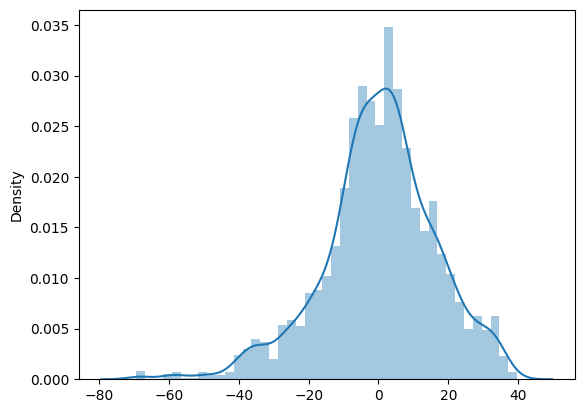

In [9]:
sns.distplot(y_test-prediction_r)

In [10]:
joblib.dump(ridge_regressor,'iplmodel_ridge.sav')

['iplmodel_ridge.sav']